In [3]:
import pandas as pd

# download URL obfuscated
df_visualcrossing = pd.read_csv("https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/retrievebulkdataset?&XXXXX&zip=false")

In [5]:
df_visualcrossing.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"43.07851797987259, 141.3252055153419",2022-08-21T00:00:00,20.1,20.1,19.2,94.57,0,0,NaN,0,...,1000.8,89.3,8.4,0,0.0,0,10,Partially cloudy,partly-cloudy-night,"47425099999,47412099999,47434099999,RJCC"
1,"43.07851797987259, 141.3252055153419",2022-08-21T01:00:00,19.7,19.7,19.0,95.81,0,0,NaN,0,...,1000.3,75.5,5.1,0,0.0,0,10,Partially cloudy,partly-cloudy-night,"47425099999,47434099999,RJCC"
2,"43.07851797987259, 141.3252055153419",2022-08-21T02:00:00,19.1,19.1,18.4,95.79,0,0,NaN,0,...,1001.0,93.9,1.7,0,0.0,0,10,Overcast,cloudy,"47425099999,47434099999,RJCC"
3,"43.07851797987259, 141.3252055153419",2022-08-21T03:00:00,17.7,17.7,15.2,85.33,0,0,NaN,0,...,1001.3,95.4,19.9,0,0.0,0,10,Overcast,cloudy,"47425099999,47412099999,47434099999,RJCC"
4,"43.07851797987259, 141.3252055153419",2022-08-21T04:00:00,17.4,17.4,17.0,97.85,0,0,NaN,0,...,1002.0,50.0,1.0,0,0.0,0,10,Partially cloudy,partly-cloudy-night,"47425099999,47434099999,RJCC"


In [21]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f


spark = SparkSession.builder.config("spark.jars", "postgresql-42.7.1.jar").getOrCreate()

jma_sqlquery = """
WITH
  races AS (
  SELECT * FROM jrdb_staging.stg_jrdb__bac WHERE "開催キー" = '012224'
  ),
  weather AS (
  SELECT * FROM jrdb_staging.stg_jma__weather_hourly WHERE station_name = '札幌'
  )

SELECT
    r.レースキー_Ｒ,
    r.年月日, 
    r.発走時間, 
	w1.気温 気温_1,
	w2.気温 気温_2,
    CASE 
        WHEN w1.気温 IS NOT NULL AND w2.気温 IS NOT NULL THEN
            w1.気温 + (w2.気温 - w1.気温) * (EXTRACT(MINUTE FROM r.発走時間)::float / 60)
        ELSE 
            COALESCE(w1.気温, w2.気温)
    END as interpolated_temperature
FROM 
    races r
LEFT JOIN 
    weather w1 ON w1.年月日時 = (r.年月日 || ' ' || LPAD((EXTRACT(HOUR FROM r.発走時間)::int)::text, 2, '0') || ':00:00')::timestamp
LEFT JOIN 
    weather w2 ON w2.年月日時 = (r.年月日 || ' ' || LPAD((EXTRACT(HOUR FROM r.発走時間)::int + 1)::text, 2, '0') || ':00:00')::timestamp
ORDER BY
  レースキー_Ｒ
"""

options = {
    "url": "jdbc:postgresql://localhost:5432/jrdb",
    "user": "admin",
    "password": "admin",
    "driver": "org.postgresql.Driver",
    "query": jma_sqlquery
}


df_jma = spark.read.format("jdbc").options(**options).load().toPandas()

In [22]:
df_jma = df_jma.assign(
    datetime=lambda x: pd.to_datetime(x["年月日"].astype(str) + " " + df_jma["発走時間"].dt.time.astype(str))
)

df_jma

,レースキー_Ｒ,年月日,発走時間,気温_1,気温_2,interpolated_temperature,datetime
0,01,2022-08-21,1970-01-01 10:10:00,25.700000000000000000,26.800000000000000000,25.883333,2022-08-21 10:10:00
1,02,2022-08-21,1970-01-01 10:45:00,25.700000000000000000,26.800000000000000000,26.525000,2022-08-21 10:45:00
2,03,2022-08-21,1970-01-01 11:15:00,26.800000000000000000,27.300000000000000000,26.925000,2022-08-21 11:15:00
3,04,2022-08-21,1970-01-01 11:45:00,26.800000000000000000,27.300000000000000000,27.175000,2022-08-21 11:45:00
4,05,2022-08-21,1970-01-01 12:35:00,27.300000000000000000,27.300000000000000000,27.300000,2022-08-21 12:35:00
5,06,2022-08-21,1970-01-01 13:05:00,27.300000000000000000,28.300000000000000000,27.383333,2022-08-21 13:05:00
6,07,2022-08-21,1970-01-01 13:35:00,27.300000000000000000,28.300000000000000000,27.883333,2022-08-21 13:35:00
7,08,2022-08-21,1970-01-01 14:05:00,28.300000000000000000,27.800000000000000000,28.258333,2022-08-21 14:05:00
8,09,2022-08-21,1970-01-01 14:35:00,28.300000000000000000,27.800000000000000000,28.008333,2022-08-21 14:35:00
9,10,2022-08-21,1970-01-01 15:10:00,27.800000000000000000,27.800000000000000000,27.800000,2022-08-21 15:10:00


# A quick check on a single example shows temperatures align OK

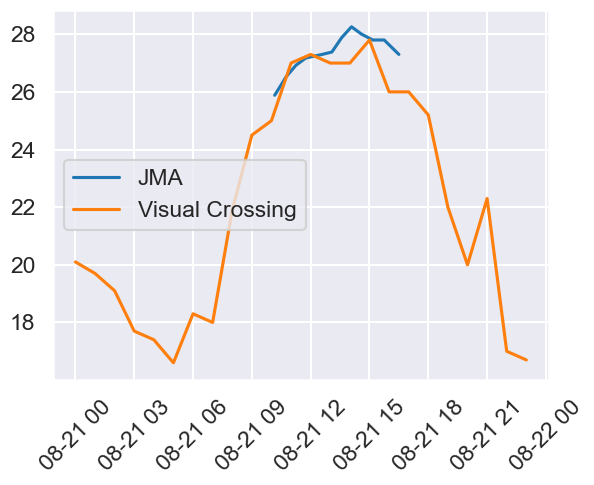

In [23]:
# compare df_visualcrossing and df_jma temperature values in plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set_context("talk")

fig, ax = plt.subplots()
ax.plot(df_jma["datetime"], df_jma["interpolated_temperature"], label="JMA")
ax.plot(pd.to_datetime(df_visualcrossing["datetime"]), df_visualcrossing["temp"], label="Visual Crossing")
ax.legend()

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.show()